# Sharpe Ratio Inference

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as ss
import cufflinks as cf

np.random.seed(222)

cf.go_offline()

In [2]:
# function to simulate normal distributed daily returns 
def generate_returns(ann_return, sharpe, size, start_date='2000-01-01'):
    mean = (1 + ann_return)**(1/252) - 1
    std = (np.sqrt(252) * mean) / sharpe
    returns = np.random.normal(mean, std, size)
    
    returns = pd.Series(
        returns,
        index=pd.bdate_range(start_date, periods=len(returns))
    )
    return returns

In [3]:

# Model daily returns with Normal distribution
def model_returns_normal(returns, sample=2000):
    with pm.Model() as model:
        mu = pm.Normal('mean returns', mu=0, sd=.01)
        sigma = pm.HalfCauchy('volatility', beta=1)
        returns = pm.Normal(
            'returns', 
            mu=mu, 
            sd=sigma, 
            observed=returns
        )
        pm.Deterministic(
            'annual volatility',
            returns.distribution.variance**0.5 *
            np.sqrt(252)
        )
        pm.Deterministic(
            'sharpe',
            returns.distribution.mean /
            returns.distribution.variance**0.5 *
            np.sqrt(252)
        )
        trace = pm.sample(sample, target_accept=0.9)

    return model, trace


# Model daily returns with StudentT distribution
def model_returns_t(returns, sample=2000):
    with pm.Model() as model:
        mu = pm.Normal('mean_returns', mu=0, sd=0.1)
        sigma = pm.HalfCauchy('volatility', beta=1)
        nu = pm.Exponential('nu_minus_2', 1 / 10)
        returns = pm.StudentT(
            'returns', 
            nu=nu + 2, 
            mu=mu, 
            sd=sigma, 
            observed=returns
        )
        pm.Deterministic(
            'annual_volatility',
            returns.distribution.variance**0.5 *
            np.sqrt(252)
         )
        pm.Deterministic(
            'sharpe',
            returns.distribution.mean /
            returns.distribution.variance**0.5 *
            np.sqrt(252)
        )
        trace = pm.sample(sample, target_accept=0.9)
        
    return model, trace

### Case 1 - Normal daily returns

In [4]:
returns_1 = generate_returns(ann_return=0.07, sharpe=1, size=15*252)

returns_1.iplot('hist')

In [5]:
returns_1.add(1).cumprod().iplot()

In [6]:
empirical_sharpe_1 = returns_1.mean() / returns_1.std() * np.sqrt(252)
empirical_sharpe_1.round(2)

1.0

In [7]:
ss.skew(returns_1)

0.019942905449777233

In [8]:
ss.kurtosis(returns_1)

0.05514125380976154

#### Case 1 - Normal model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility, mean returns]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.


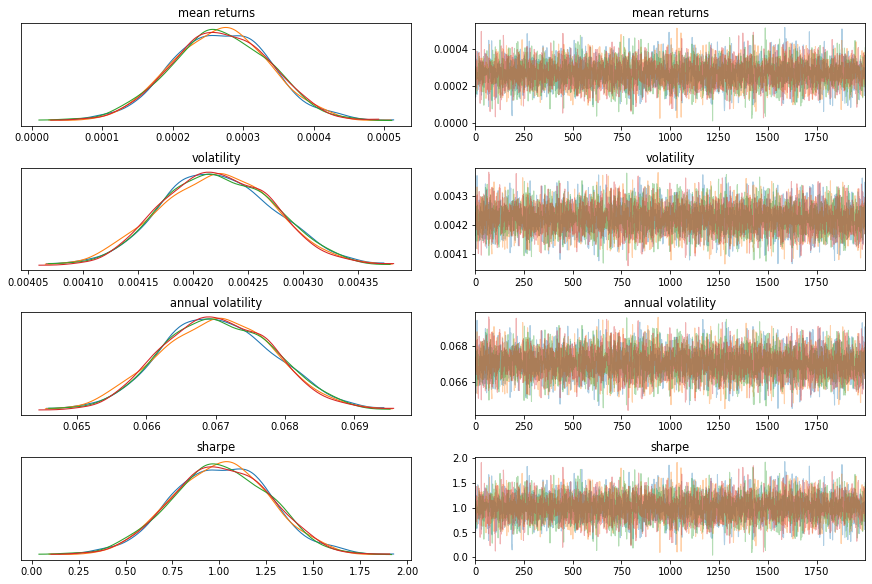

In [9]:
model_1_1, trace_1_1 = model_returns_normal(returns_1)

with model_1_1:
    pm.plot_trace(trace_1_1)

In [10]:
np.median(trace_1_1['sharpe']).round(2)

1.0

In [11]:
np.quantile(trace_1_1['sharpe'], q=[0.025, 0.975]).round(2)

array([0.5 , 1.51])

In [12]:
(trace_1_1['sharpe'] < 0).mean().round(2)

0.0

In [13]:
trace_1_1['sharpe'].std().round(2)

0.26

#### Case 1 - StudentT model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_2, volatility, mean_returns]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.


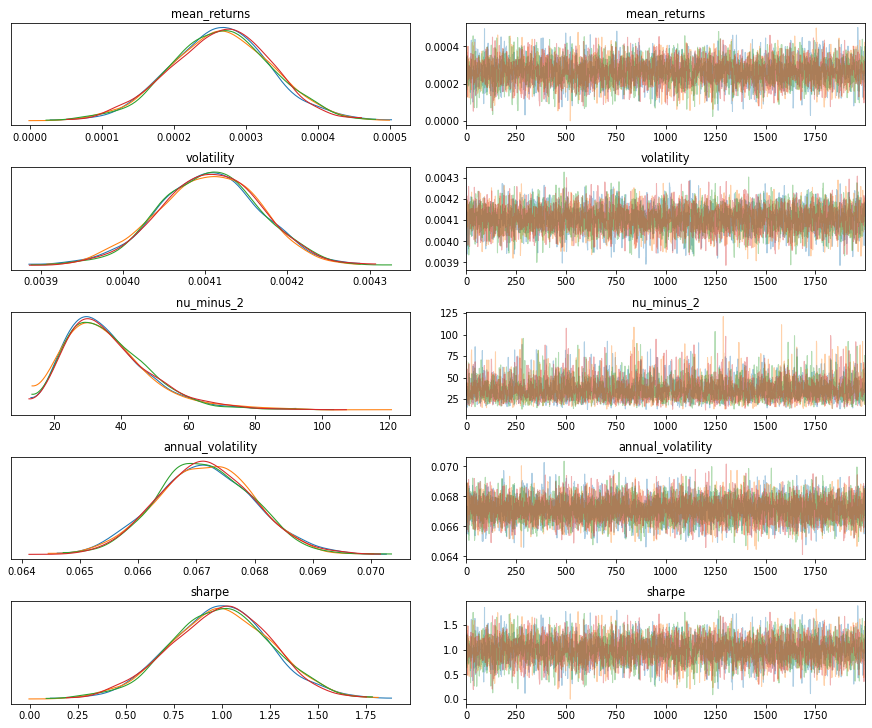

In [14]:
model_1_2, trace_1_2 = model_returns_t(returns_1)

with model_1_2:
    pm.plot_trace(trace_1_2)

In [15]:
np.median(trace_1_2['sharpe']).round(2)

0.99

In [16]:
np.quantile(trace_1_2['sharpe'], q=[0.025, 0.975]).round(2)

array([0.47, 1.5 ])

In [17]:
(trace_1_2['sharpe'] < 0).mean().round(2)

0.0

In [18]:
trace_1_2['sharpe'].std().round(2)

0.26

### Case 2 - Fat tailed returns with negative skew

In [19]:
np.random.seed(99)

size = 15*252
size_r1 = int(0.85*size)
size_r2 = int(0.14*size)
size_r3 = size - size_r1 - size_r2

r1 = generate_returns(ann_return=+0.10, sharpe=0.85, size=size_r1)
r2 = generate_returns(ann_return=+1, sharpe=3, size=size_r2)
r3 = generate_returns(ann_return=-0.9999999999999999, sharpe=-40, size=size_r3)

idxs = np.arange(size)
idxs_r1 = np.random.choice(idxs, size=size_r1, replace=False)

idxs = np.setdiff1d(idxs, idxs_r1)
idxs_r2 = np.random.choice(idxs, size=size_r2, replace=False)
idxs_r3 = np.setdiff1d(idxs, idxs_r2)

returns_2 = np.zeros(size)
returns_2[idxs_r1] = r1
returns_2[idxs_r2] = r2
returns_2[idxs_r3] = r3

returns_2 = pd.Series(returns_2)
returns_2.index = pd.bdate_range('2000', periods=len(returns_2))

returns_2.iplot('hist')

In [20]:
returns_2.add(1).cumprod().iplot()

In [21]:
returns_2.add(1).cumprod().apply(np.log).iplot()

In [22]:
empirical_sharpe_2 = returns_2.mean() / returns_2.std() * np.sqrt(252)
empirical_sharpe_2.round(2)

-0.33

In [23]:
ss.skew(returns_2)

-7.4139114128182895

In [24]:
ss.kurtosis(returns_2)

76.96714457846996

#### Case 2 - Normal model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility, mean returns]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 44 seconds.


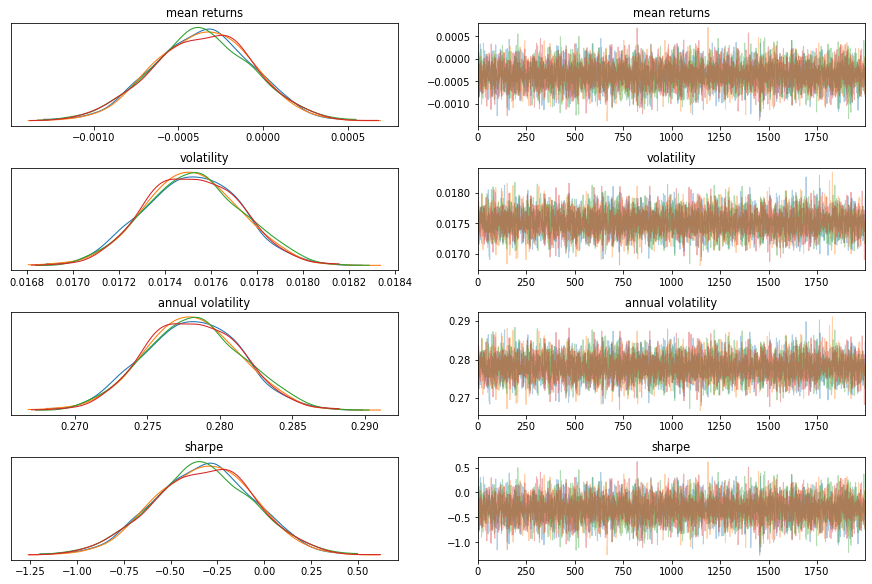

In [25]:
model_2_1, trace_2_1 = model_returns_normal(returns_2)

with model_2_1:
    pm.plot_trace(trace_2_1)

In [26]:
np.median(trace_2_1['sharpe']).round(2)

-0.32

In [27]:
np.quantile(trace_2_1['sharpe'], q=[0.025, 0.975]).round(2)

array([-0.84,  0.18])

In [28]:
(trace_2_1['sharpe'] < 0).mean().round(2)

0.9

In [29]:
trace_2_1['sharpe'].std().round(2)

0.26

#### Case 2 - StudentT model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_2, volatility, mean_returns]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.


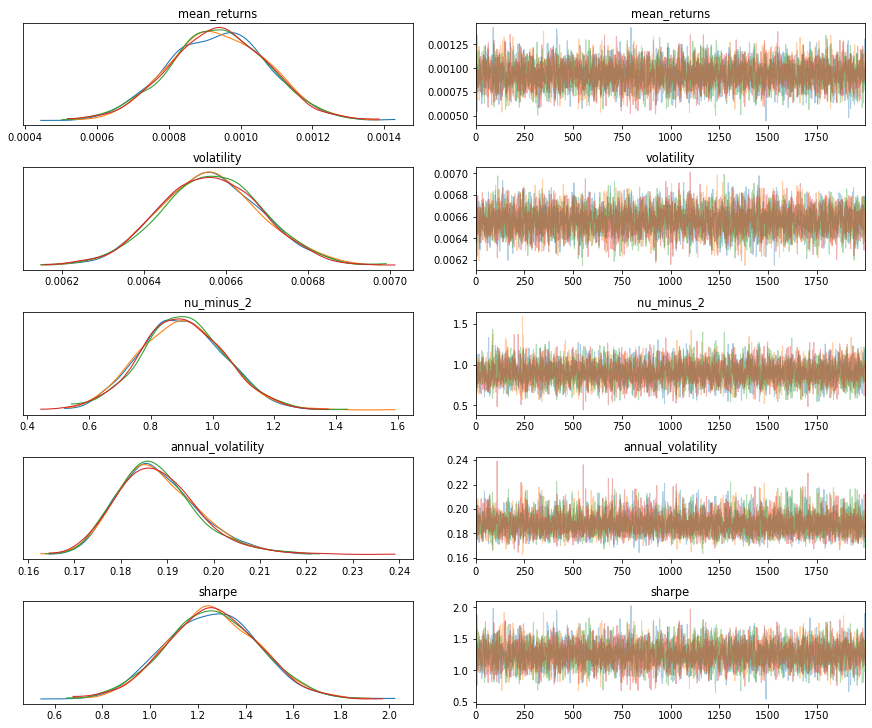

In [30]:
model_2_2, trace_2_2 = model_returns_t(returns_2)

with model_2_2:
    pm.plot_trace(trace_2_2)

In [31]:
np.median(trace_2_2['sharpe']).round(2)

1.26

In [32]:
np.quantile(trace_2_2['sharpe'], q=[0.025, 0.975]).round(2)

array([0.89, 1.64])

In [33]:
(trace_2_2['sharpe'] < 0).mean().round(2)

0.0

In [34]:
trace_2_2['sharpe'].std().round(2)

0.19